In [36]:
import pandas as pd
import numpy as np
from ripser import ripser
from persim import plot_diagrams
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons
from matplotlib.lines import Line2D
import matplotlib
import warnings
import os
from data_cleaning import (
    calculate_indicator_summary, 
    summarize_data_wide, 
    input_missing_data, 
    standardize)
from homology import (
    safe_linspace,
    stable_rank,
    betti_curve,
    safe_interp
)

In [37]:
# ------------------------------
# 1. Load data
# ------------------------------
data_dir = "C:/Users/padil/Documents/TDA/DATA/"

data_countries = pd.read_csv(os.path.join(data_dir, "Data_countries_extended.csv")) # Data for countries
data_regions = pd.read_csv(os.path.join(data_dir, "Data_regions_extended.csv")) # Data for regions
world_regions_latest = pd.read_csv(os.path.join(data_dir,"clean_world_regions.csv")) # Map of countries into regions
happiness_raw = pd.read_csv(os.path.join(data_dir,"Happiness_data.csv"), encoding='latin-1') 
democracy_raw = pd.read_csv(os.path.join(data_dir,"democracy-index-eiu.csv"), ) 

In [38]:
happiness = happiness_raw[['Year', 'Country name', 'Life evaluation (3-year average)']].loc[happiness_raw['Country name'].notna() & (happiness_raw['Year'] == 2024.0)]
happiness['Happiness'] = pd.cut(x=happiness['Life evaluation (3-year average)'], bins=[0, 6, 8],
                     labels=[0,1])

In [39]:
democracy = democracy_raw.loc[democracy_raw['Code'].notna() & (democracy_raw['Year'] == 2024.0)].copy()
democracy['Democracy'] = pd.cut(x=democracy['Democracy index'], bins=[0, 4, 6, 8, 10],
                     labels=[0,1,2, 3])
democracy['Democracy label'] = pd.cut(x=democracy['Democracy index'], bins=[0, 4, 6, 8, 10],
                     labels=["full democracy", "flawed democracy", "hybrid regime", "authoritarian regime"])

In [40]:
# ------------------------------
# 2. Mappings
# ------------------------------
indicators = {
    'NY.GDP.PCAP.CD': 'gdp_per_capita',
    'NY.GDP.MKTP.KD.ZG': 'gdp_growth',
    'SP.DYN.LE00.IN': 'life_expectancy',
    'SP.DYN.IMRT.IN': 'infant_mortality',
    'SE.SEC.ENRR': 'school_enrollment',
    #'SE.ADT.LITR.ZS': 'literacy_rate',
    'SH.XPD.CHEX.GD.ZS': 'health_spending',
    #'SI.POV.GINI': 'gini',
    'SI.POV.DDAY': 'poverty',
    'SP.POP.GROW': 'pop_growth',
    'EG.ELC.ACCS.ZS': 'electricity_access',
    'SM.POP.NETM': 'migration',
    'NV.AGR.TOTL.ZS': 'agriculture_weight_GDP',
    'SE.XPD.TOTL.GD.ZS': 'education spending'
}

wb_region_map = {
    "Latin America and Caribbean (WB)": "Latin America & Caribbean",
    "Sub-Saharan Africa (WB)": "Sub-Saharan Africa",
    "East Asia and Pacific (WB)": "East Asia & Pacific",
    "Europe and Central Asia (WB)": "Europe & Central Asia",
    "Middle East, North Africa, Afghanistan and Pakistan (WB)": "Middle East, North Africa, Afghanistan & Pakistan",
    "South Asia (WB)": "South Asia",
    "North America (WB)": "North America"
}

In [41]:
import pandas as pd
import numpy as np

# 2. Define a function to find the column names that are True (NaN)
def find_nan_columns(row):
    """Returns a list of column names that are NaN (True in the boolean mask)."""
    return row[row].index.tolist()


In [42]:
# ------------------------------
# 3. Build data matrix by filling empty indicators and dropping non-filled enough countries
# ------------------------------
calculations = ['median']

# Country level data
data_wide = summarize_data_wide(data_countries, indicators, calculations)

country_region_map = world_regions_latest.set_index('Code')['World regions according to WB'].map(wb_region_map).to_dict()
data_wide['region'] = data_wide['Country Code'].map(country_region_map)

# Region level data
data_region_wide = summarize_data_wide(data_regions, indicators, calculations)
data_region_wide = data_region_wide.rename(columns={'Country Name': 'region'})

data_wide_full = input_missing_data(data_wide, data_region_wide)

if 'gdp_per_capita' in data_wide_full.columns: # Log-transform GDP per capita safely
    data_wide_full['gdp_per_capita'] = data_wide_full['gdp_per_capita'].apply(lambda x: np.log10(x) if x>0 else np.nan)

X, countries, regions = standardize(data_wide_full)

In [43]:
happiness_scores = happiness[['Country name', 'Happiness']]

happiness_data = data_wide_full.merge(
    happiness_scores,
    left_on='Country Name',  # Column from data_wide_full
    right_on='Country name', # Column from happiness_scores
    how='inner'
)
label_happ = happiness_data['Happiness'].values
happiness_data = happiness_data.drop(columns=['Country name', 'Happiness'])

X_happ, _, _ = standardize(happiness_data)


In [44]:
democracy_scores = democracy[['Code', 'Democracy']]

democracy_data = data_wide_full.merge(
    democracy_scores,
    left_on='Country Code',  # Column from data_wide_full
    right_on='Code', # Column from happiness_scores
    how='inner'
)
label_dem = democracy_data['Democracy'].values
democracy_data = democracy_data.drop(columns=['Code', 'Democracy'])

X_dem, _, _ = standardize(democracy_data)

In [45]:
analysis_type = 0
if analysis_type==0:
    X_data = X
elif analysis_type==1:
    X_data = X_happ
else:
    X_data = X_dem
n_samples = len(X_data)

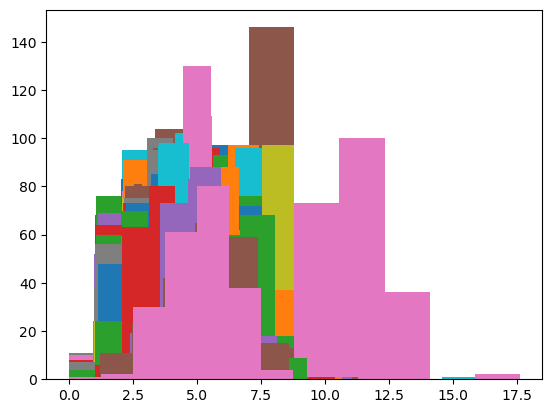

In [46]:
dist_matrix = squareform(pdist(X_data, metric='euclidean'))

for i in range(len(X_data)):
    plt.hist(dist_matrix[i])

Processing distribution: 0_4
Processing distribution: 2_6
Processing distribution: 4_8
Processing distribution: 6_10


c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose

Processing distribution: 8_12


c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:25

Processing distribution: 10_14


c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
c:\Users\padil\anaconda3\envs\tda_env\Lib\site-packages\ripser\ripser.py:25

Processing distribution: 12_16
Processing distribution: 0_16


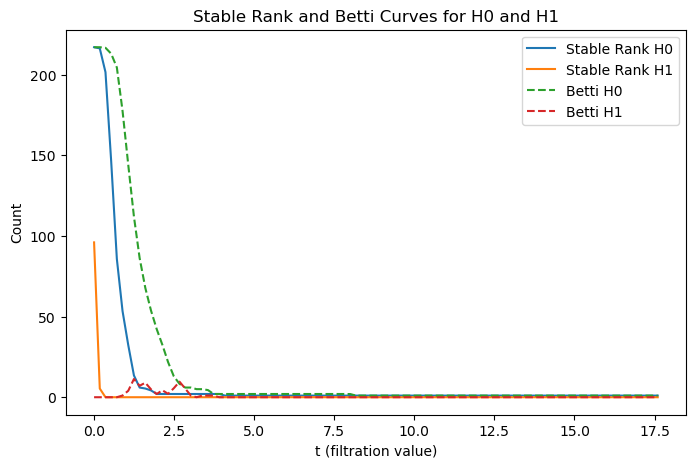

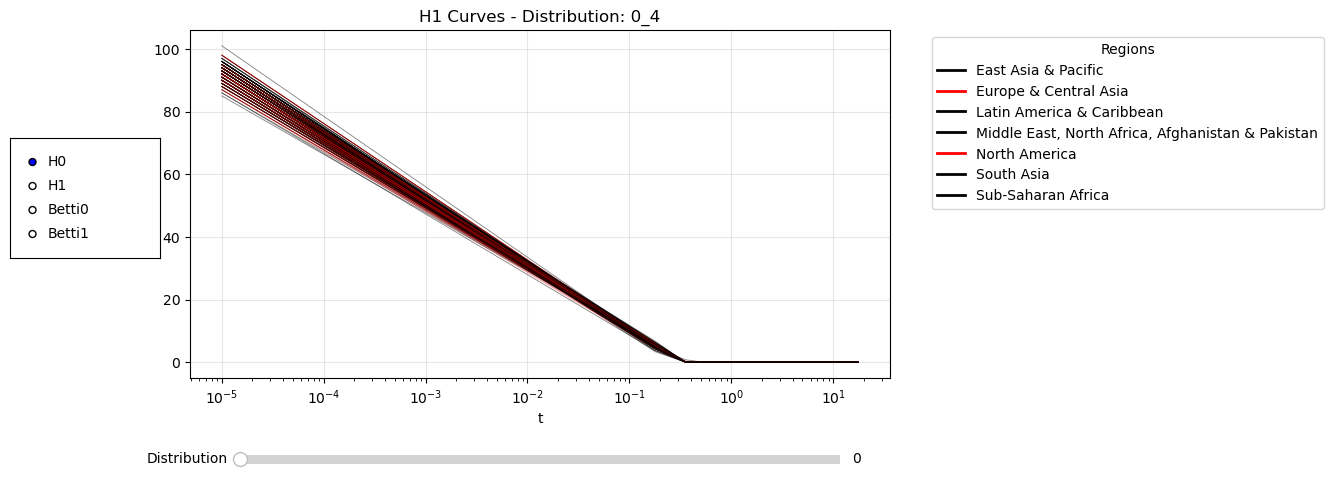

In [47]:
unique_regions = sorted(set(regions))
cmap = matplotlib.colormaps.get_cmap("tab10").resampled(len(unique_regions))
region_colors = {region: cmap(i) for i, region in enumerate(unique_regions)}

hemisphere_colors = {}
for region in unique_regions:
    if region in ["East Asia & Pacific", "Latin America & Caribbean", "Middle East, North Africa, Afghanistan & Pakistan", "South Asia", "Sub-Saharan Africa"]:
        hemisphere_colors[region] = "black"
    elif region in ["Europe & Central Asia", "North America"]:
        hemisphere_colors[region] = "red"
    elif region in ["authoritarian regime", "hybrid regime"]:
        hemisphere_colors[region] = "black"
    elif region in ["flawed democracy","full democracy"]:
        hemisphere_colors[region] = "red"
    else:
        # fallback (optional)
        hemisphere_colors[region] = "gray"

metrics = ["euclidean"] # , "hamming", "mahalanobis"
for metric in metrics:
    dist_matrix = squareform(pdist(X_data, metric=metric))

    rips = ripser(dist_matrix, maxdim=1, distance_matrix=True)
    plt.figure()
    plot_diagrams(rips['dgms'], show=False, title="Persistence Diagrams")
    #plt.savefig(f"Persistence_{metric}.pdf", bbox_inches='tight')
    plt.close()

    homology_results = {}

    for dim, label in enumerate(["H0", "H1"]):
        diagram = rips["dgms"][dim]
        t_vals = safe_linspace(diagram, num=100, default_max=np.max(dist_matrix))

        # Stable Rank and Betti
        sr = stable_rank(diagram, t_vals, include_infinite=True)
        betti = betti_curve(diagram, t_vals)

        # Interpolate to a common t-grid (for comparison)
        t_uniform = np.linspace(0, np.max(dist_matrix), 100)
        sr_interp = safe_interp(t_uniform, t_vals, sr)
        betti_interp = safe_interp(t_uniform, t_vals, betti)

        homology_results[label] = {
            "diagram": diagram,
            "t_vals": t_vals,
            "sr": sr,
            "betti": betti,
            "t_uniform": t_uniform,
            "sr_uniform": sr_interp,
            "betti_uniform": betti_interp,
        }

    sr_H0 = homology_results["H0"]["sr_uniform"]
    betti_H0 = homology_results["H0"]["betti_uniform"]
    sr_H1 = homology_results["H1"]["sr_uniform"]
    betti_H1 = homology_results["H1"]["betti_uniform"]
    t_vals = homology_results["H0"]["t_uniform"]

    # Sampling
    number_data_points = X_data.shape[0]

    def uniform_distribution_interval(low, high):
        def f(distances):
            prob = np.clip((distances - low) / (high - low), 0, 1)
            if prob.sum() == 0:
                return np.ones_like(prob) / len(prob)
            return prob / prob.sum()
        return f

    distributions = {
        # "0_50": uniform_distribution_interval(0, 50),
        # "25_75": uniform_distribution_interval(25, 75),
        # "50_100": uniform_distribution_interval(50, 100),
        # "75_125": uniform_distribution_interval(75, 125),
        # "100_150": uniform_distribution_interval(100, 150),
        # "125_175": uniform_distribution_interval(125, 175),
        # "150_200": uniform_distribution_interval(150, 200),

        "0_4": uniform_distribution_interval(0, 4),
        "2_6": uniform_distribution_interval(2, 6),
        "4_8": uniform_distribution_interval(4, 8),
        "6_10": uniform_distribution_interval(6, 10),
        "8_12": uniform_distribution_interval(8, 12),
        "10_14": uniform_distribution_interval(10, 14),
        "12_16": uniform_distribution_interval(12, 16),
        "0_16": uniform_distribution_interval(0, 16),

    }

    number_instances = 100    # number of random samples per base point
    sample_size = 10          # number of points in each sample
    t_len = 100               # number of t-values
    t_global = np.linspace(0, np.max(dist_matrix), t_len)  # common t-grid

    sr_H0_samp, sr_H1_samp = {k: [] for k in distributions}, {k: [] for k in distributions}
    betti_H0_samp, betti_H1_samp = {k: [] for k in distributions}, {k: [] for k in distributions}

    # --- Main sampling loop ---
    for k, dist_func in distributions.items():
        print(f"Processing distribution: {k}")
        for i in range(number_data_points):
            p = dist_func(dist_matrix[i])

            # Generate multiple random subsets
            sampled_indices = []
            for _ in range(number_instances):
                sampled_indices.append(np.random.choice(number_data_points, size=sample_size, p=p))
            sampled_indices = np.unique(np.concatenate(sampled_indices))

            # Skip trivial subsets
            if len(sampled_indices) < 2:
                sr_H0_samp[k].append(np.zeros(t_len))
                sr_H1_samp[k].append(np.zeros(t_len))
                betti_H0_samp[k].append(np.zeros(t_len))
                betti_H1_samp[k].append(np.zeros(t_len))
                continue

            X_subset = X_data[sampled_indices]
            rips = ripser(X_subset, maxdim=1)
            H0_dgm, H1_dgm = rips['dgms']

            # H0 computations
            t_local_H0 = safe_linspace(H0_dgm, t_len, default_max=np.max(dist_matrix))
            sr0 = stable_rank(H0_dgm, t_local_H0)
            betti0 = betti_curve(H0_dgm, t_local_H0)
            sr_H0_samp[k].append(safe_interp(t_global, t_local_H0, sr0))
            betti_H0_samp[k].append(safe_interp(t_global, t_local_H0, betti0))

            # H1 computations
            t_local_H1 = safe_linspace(H1_dgm, t_len, default_max=np.max(dist_matrix))
            sr1 = stable_rank(H1_dgm, t_local_H1)
            betti1 = betti_curve(H1_dgm, t_local_H1)
            sr_H1_samp[k].append(safe_interp(t_global, t_local_H1, sr1))
            betti_H1_samp[k].append(safe_interp(t_global, t_local_H1, betti1))

    plt.figure(figsize=(8, 5))
    plt.plot(t_vals, sr_H0, label="Stable Rank H0")
    plt.plot(t_vals, sr_H1, label="Stable Rank H1")
    plt.plot(t_vals, betti_H0, '--', label="Betti H0")
    plt.plot(t_vals, betti_H1, '--', label="Betti H1")
    plt.xlabel("t (filtration value)")
    plt.ylabel("Count")
    plt.title("Stable Rank and Betti Curves for H0 and H1")
    plt.legend()
    plt.show()


    # --- Distributions ---
    distribution_names = list(distributions.keys())
    n_distributions = len(distribution_names)
    number_samples = n_samples

    # --- Homology / curves dictionaries ---
    homology_types = {
        'H0': sr_H0_samp,
        'H1': sr_H1_samp,
        'Betti0': betti_H0_samp,
        'Betti1': betti_H1_samp
    }
    homology_labels = ['H0', 'H1', 'Betti0', 'Betti1']

    # --- Initial settings ---
    current_homology = 'H1'
    current_distribution = 0  # index into distribution_names

    # --- Handle t=0 for log scale ---
    epsilon = 1e-5
    t_plot = np.maximum(t_global, epsilon)

    # --- Create figure ---
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.subplots_adjust(bottom=0.3, left=0.2)
    ax.set_xscale('log')  # log scale
    ax.set_xlabel("t")
    ax.set_ylabel(current_homology)
    ax.grid(alpha=0.3)

    # --- Initial plot lines ---
    lines = []
    for i in range(number_samples):
        region = regions[i]
        curve_dict = homology_types[current_homology]
        curve = curve_dict[distribution_names[current_distribution]][i]
        #line, = ax.plot(t_plot, curve, color=region_colors[region], alpha=0.5, lw=0.6)
        line, = ax.plot(t_plot, curve, color=hemisphere_colors[region], alpha=0.5, lw=0.6)
        lines.append(line)

    ax.set_title(f"{current_homology} Curves - Distribution: {distribution_names[current_distribution]}")

    # --- Slider for distributions ---
    ax_slider = plt.axes([0.25, 0.15, 0.6, 0.03])
    slider = Slider(ax_slider, 'Distribution', 0, n_distributions-1,
                    valinit=current_distribution, valstep=1, valfmt='%0.0f')

    # --- Radio buttons for homology type ---
    ax_radio_hom = plt.axes([0.02, 0.5, 0.15, 0.2])
    radio_hom = RadioButtons(ax_radio_hom, homology_labels)

    # --- Update functions ---
    def update_slider(val):
        idx = int(slider.val)
        dist_name = distribution_names[idx]
        for i in range(number_samples):
            region = regions[i]
            curve_dict = homology_types[current_homology]
            lines[i].set_ydata(curve_dict[dist_name][i])
            #lines[i].set_color(region_colors[region])
            lines[i].set_color(hemisphere_colors[region])
        ax.set_title(f"{current_homology} Curves - Distribution: {dist_name}")
        fig.canvas.draw_idle()

    max_t_H0 = np.max([np.max(curve) for k in distributions.keys() for curve in sr_H0_samp[k]])
    max_t_H1 = np.max([np.max(curve) for k in distributions.keys() for curve in sr_H1_samp[k]])

    def update_homology(label):
        global current_homology
        current_homology = label
        ax.set_ylabel(current_homology)
        
        # --- x-axis scale ---
        if current_homology in ['H1', 'Betti1']:
            ax.set_xscale('log')
            ax.set_xlim(np.min(t_plot), np.max(t_plot))  # use t_plot for log
        else:
            ax.set_xscale('linear')
            if current_homology in ['H0']:
                ax.set_xlim(0, 1.5)
            elif current_homology in ['Betti0']:
                ax.set_xlim(0, 2.5)
            else:
                ax.set_xlim(0, np.max(t_global))
        
        # --- y-axis scaling ---
        if current_homology in ['H0', 'Betti0']:
            ax.set_ylim(0, np.max([np.max(sr_H0_samp[k][current_distribution]) for k in distributions]))
        else:  # H1 or Betti1
            ax.set_ylim(0, np.max([np.max(sr_H1_samp[k][current_distribution]) for k in distributions]))
        
        update_slider(slider.val)

    slider.on_changed(update_slider)
    radio_hom.on_clicked(update_homology)

    # --- Legend for regions ---
    #legend_elements = [Line2D([0],[0], color=region_colors[r], lw=2, label=r) for r in unique_regions]
    legend_elements = [Line2D([0],[0], color=hemisphere_colors[r], lw=2, label=r) for r in unique_regions]
    ax.legend(handles=legend_elements, title="Regions", bbox_to_anchor=(1.05,1), loc='upper left')

    plt.show()
    



# Classif

In [48]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from datetime import timedelta



In [49]:
region = data_wide['region']
south = ["East Asia & Pacific", "Latin America & Caribbean", "Middle East, North Africa, Afghanistan & Pakistan", "South Asia", "Sub-Saharan Africa"]
label_region = region.apply(lambda x: 1 if x in south else 0).values

In [50]:
if analysis_type == 0:
    data = data_wide_full.copy()
    label = label_region
elif analysis_type==1:
    data = happiness_data.copy()
    label = label_happ
else:
    data = democracy_data.copy()
    label = label_dem
    

X_train, X_test, y_train, y_test = train_test_split(np.arange(len(data)), 
                                                    label, 
                                                    test_size=0.3)

In [51]:
train = [X_data[i] for i in X_train]
test = [X_data[i] for i in  X_test]

start = timer()    

kernel_train = np.asarray([[np.dot(f,g) for g in train] for f in train])
kernel_test = np.asarray([[np.dot(f,g) for g in train] for f in test])

end = timer()
print(timedelta(seconds=end-start))

0:00:00.038279


In [52]:
clf = svm.SVC(kernel='precomputed')
clf.fit(kernel_train, y_train)
prediction = clf.predict(kernel_test )
a_score = accuracy_score(y_test, prediction)
print("classification accuracy: ", a_score)

classification accuracy:  0.8939393939393939


In [53]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
loo = LeaveOneOut()
model = svm.SVC(kernel='linear')
scores = cross_val_score(model, X_data, label, cv=loo)
print(scores.mean())

0.8847926267281107


In [54]:
h0_kernel_train = {}
h0_kernel_test = {}
h0_prediction = {}
h0_a_score = {}
start = timer()  
loo = LeaveOneOut()

for k in distributions.keys():
    # h0_train = [sr_H0_samp[k][i] for i in X_train]
    # h0_test = [sr_H0_samp[k][i] for i in X_test]
    # kernel_train = np.asarray([[f.dot(g) for g in h0_train] for f in h0_train])
    # kernel_test = np.asarray([[f.dot(g) for g in h0_train] for f in h0_test])
    # h0_kernel_train[k] = kernel_train
    # h0_kernel_test[k] = kernel_test
    # clf = svm.SVC(kernel='precomputed')
    # clf.fit(kernel_train, y_train)
    # pred = clf.predict(kernel_test )
    # h0_prediction[k] = pred
    # h0_a_score[k] = accuracy_score(y_test, pred)
    model = svm.SVC(kernel='linear')
    scores = cross_val_score(model, sr_H0_samp[k], label, cv=loo)
    h0_a_score[k] = scores.mean()
    h0_prediction[k] = scores
end = timer()
print("h0 pred: ", timedelta(seconds=end-start))

h1_kernel_train = {}
h1_kernel_test = {}
h1_prediction = {}
h1_a_score = {}

start = timer()  

for k in distributions.keys():
    # h1_train = [sr_H1_samp[k][i] for i in X_train]
    # h1_test = [sr_H1_samp[k][i] for i in X_test]
    # kernel_train = np.asarray([[f.dot(g) for g in h1_train] for f in h1_train])
    # kernel_test = np.asarray([[f.dot(g) for g in h1_train] for f in h1_test])
    # h1_kernel_train[k] = kernel_train
    # h1_kernel_test[k] = kernel_test
    # clf = svm.SVC(kernel='precomputed')
    # clf.fit(kernel_train, y_train)
    # pred = clf.predict(kernel_test )
    # h1_prediction[k] = pred
    # h1_a_score[k] = accuracy_score(y_test, pred)
    model = svm.SVC(kernel='linear')
    scores = cross_val_score(model, sr_H1_samp[k], label, cv=loo)
    h1_a_score[k] = scores.mean()
    h1_prediction[k] = scores
end = timer()
print("h1 pred: ", timedelta(seconds=end-start))

h0 pred:  0:01:10.656921
h1 pred:  0:01:50.370631


In [55]:
for k in h0_a_score.keys():
    print("distribution "+k+", h0 score:", round(h0_a_score[k],2), 
          ", h1 score:", round(h1_a_score[k],2))

distribution 0_4, h0 score: 0.75 , h1 score: 0.72
distribution 2_6, h0 score: 0.77 , h1 score: 0.72
distribution 4_8, h0 score: 0.78 , h1 score: 0.67
distribution 6_10, h0 score: 0.74 , h1 score: 0.72
distribution 8_12, h0 score: 0.79 , h1 score: 0.72
distribution 10_14, h0 score: 0.76 , h1 score: 0.75
distribution 12_16, h0 score: 0.71 , h1 score: 0.72
distribution 0_16, h0 score: 0.82 , h1 score: 0.72


In [56]:
y_test[0]

np.int64(1)

In [57]:
h0_wrong_class = {}
for k in  distributions.keys():
    h0_wrong_class[k] = {}
    indx = []
    values = []
    pred = []
    for i in range(len(h0_prediction[k])):
        v = y_test[i]
        p = h0_prediction[k][i]
        if v != p:
            indx.append(i)
            values.append(v)
            pred.append(p)
        h0_wrong_class[k]["index"] = indx
        h0_wrong_class[k]["value"] = values
        h0_wrong_class[k]["prediction"] = pred

h1_wrong_class = {}
for k in  distributions.keys():
    h1_wrong_class[k] = {}
    indx = []
    values = []
    pred = []
    for i in range(len(h1_prediction[k])):
        v = y_test[i]
        p = h1_prediction[k][i]
        if v != p:
            indx.append(i)
            values.append(v)
            pred.append(p)
        h1_wrong_class[k]["index"] = indx
        h1_wrong_class[k]["value"] = values
        h1_wrong_class[k]["prediction"] = pred

IndexError: index 66 is out of bounds for axis 0 with size 66

In [ ]:
print(h1_wrong_class["0_4"]['index'])
data_wide['Country Name'].iloc[h1_wrong_class["0_4"]['index']]


[0, 1, 2, 3, 4, 6, 8, 9, 16, 17, 21, 22, 24, 31, 32, 35, 38, 40, 42, 44, 45, 47]


0                Afghanistan
1                    Albania
2                    Algeria
3             American Samoa
4                    Andorra
6        Antigua and Barbuda
8                    Armenia
9                      Aruba
16                  Barbados
17                   Belarus
21                   Bermuda
22                    Bhutan
24    Bosnia and Herzegovina
31                   Burundi
32                Cabo Verde
35                    Canada
38                      Chad
40                     Chile
42                  Colombia
44          Congo, Dem. Rep.
45               Congo, Rep.
47             Cote d'Ivoire
Name: Country Name, dtype: object